Fay Gravity Viscous spreading:

$$
\begin{align}
V_0 &= \text{volume of blob released at same time from same spill } m^3 \cr
v_w &= \text{kinematic viscosity of water } m^2/s \cr
g &= \text{gravitation constant } 9.81 m/s^2 \cr
\rho_{oil} &= \text{oil density } (kg/m^3) \cr
\rho_w &= \text{water density } (kg/m^3) \cr
F_{ow} &= \text{relative buoyancy of fresh oil when released } {\rho_w - \rho_{oil} \over \rho_w} \cr
(k_1, k_2) &= (1.53, 1.21) = \text{dimensionless constants} \cr
\delta(t) &= \text{thickness over time, stop spreading when this reaches } 0.0001 m \cr
\end{align}
$$

Initial Gravity Spreading:

$$
\begin{align}
A_0 &= \pi \cdot {k_2^4 \over k_1^2} \left( {V_0 \cdot g \cdot \Delta \over v_w^2 } \right)^{1/6} \cr
t_0 &= \left( {k_2 \over k_1} \right)^4 \left( {V_0 \over v_w \cdot g \cdot \Delta } \right)^{1/3} \cr
\end{align}
$$

Once particles are released, set their initial area to $A_0$ irrespective of time_step.  The first time step will use $A_0$ to compute evaporation.  Once age of blob, $V_0$, is greater than $t_0$, ie $t > t_0$, use the formulation below to update area until a maximum is achieved.

$$
\begin{align}
A(t) &= \pi \cdot k_2^2 \left( {V_0^2 \cdot g \cdot \Delta \over v_w^{1/2}} \right)^{1/3} \cdot t^{1/2}
\end{align}
$$

Max area for 0.0001m thickness is achieved at time $t_{MaxArea}$ as given below:

$$
\begin{align}
A_{max} &= {V_0 \over 0.0001} \cr
t_{MaxArea} &= \left( {1 \over 0.0001 \cdot \pi \cdot k_2^2} \right)^2 \left( {V_0 \cdot v_w^{1/2} \over g \cdot \Delta} \right)^{2/3}
\end{align}
$$

In [1]:
%pylab inline
from datetime import timedelta, datetime
from gnome.model import Model
from gnome.spill import point_line_release_spill
from gnome.environment import constant_wind, Water, Wind
from gnome.weatherers import (Evaporation,
                              WeatheringData)
from gnome.outputters import WeatheringOutput
from gnome.constants import gravity

Populating the interactive namespace from numpy and matplotlib
Failed to add Resin fraction!
Failed to add Asphaltene fraction!
Our initial fractions so far (SA, R, A): (0, 0, 0) total: 0
Failed to add Resin fraction!
Failed to add Asphaltene fraction!
Our initial fractions so far (SA, R, A): (0, 0, 0) total: 0
Failed to add Resin fraction!
Failed to add Asphaltene fraction!
Our initial fractions so far (SA, R, A): (0, 0, 0) total: 0
Failed to add Resin fraction!
Failed to add Asphaltene fraction!
Our initial fractions so far (SA, R, A): (0, 0, 0) total: 0
Failed to add Resin fraction!
Failed to add Asphaltene fraction!
Our initial fractions so far (SA, R, A): (0, 0, 0) total: 0
Failed to add Resin fraction!
Failed to add Asphaltene fraction!
Our initial fractions so far (SA, R, A): (0, 0, 0) total: 0


In [2]:
amount = 36000.  # kg

# Both example models will automatically add WeatheringData() and FayGravityViscous()
# make_default_refs is True by default so 'wind', 'water', environment objects are
# automatically hooked up in the first step
def setup_test(delay, num_les):
    '''
        creates two sample models to vary timestep and compare
        :param delay: if this is non-zero, it defines the end_time for release as start_time + delay.
                      Used to model a time varying spill
        :param num_les: array of length 2 = defines the number of LEs used in each model.
    '''
    stime = datetime(2015, 1, 1, 12, 0)
    etime = stime + delay
    st_pos = (0, 0, 0)
    oil = u'ALASKA NORTH SLOPE (MIDDLE PIPELINE)'
    ts = 3600.

    m1 = Model(start_time=stime, time_step=ts)
    m1.environment += [constant_wind(0, 0), Water()]
    m1.weatherers += [Evaporation()]
    m1.spills += point_line_release_spill(num_les[0], st_pos, stime,
                                          end_release_time=etime,
                                          substance=oil,
                                          amount=amount, units='kg')
    m1.outputters += WeatheringOutput()

    m2 = Model(start_time=stime, time_step=ts)
    m2.environment += [constant_wind(0, 0), Water()]
    m2.weatherers += [Evaporation()]
    m2.spills += point_line_release_spill(num_les[1], st_pos, stime,
                                          end_release_time=etime,
                                          substance=oil,
                                          amount=amount, units='kg')
    m2.outputters += WeatheringOutput()
    return m1, m2


In [3]:
# modeled as 1 LE
m1, m2 = setup_test(timedelta(0), (1, 1))

m1.time_step = 900
m1.duration = timedelta(hours=24 * 5)

m2.time_step = 100
m2.duration = timedelta(hours=24 * 5)

In [4]:
t1 = []
evap1 = []
fay_area1 = []
rho1 = []
m1.rewind()

sc1 =  m1.spills.items()[0]
while m1.current_time_step < m1.num_time_steps - 1:
    w1 = m1.step()['WeatheringOutput']
    area = sc1['fay_area'][0] * len(sc1)
    time = (m1.model_time - m1.start_time).total_seconds()
    
    t1.append(time)
    evap1.append(w1['evaporated'])
    rho1.append(w1['avg_density'])
    fay_area1.append(area)
print 'done looping...'

evap1 = np.array(evap1)
fay_area1 = np.array(fay_area1)
rho1 = np.array(rho1)
t1 = np.array(t1)


done looping...


In [5]:
t2 = []
evap2 = []
fay_area2 = []
rho2 = []
m2.rewind()

sc2 =  m2.spills.items()[0]
while m2.current_time_step < m2.num_time_steps - 1:
    w2 = m2.step()['WeatheringOutput']
    area = sc2['fay_area'][0] * len(sc2)
    time = (m2.model_time - m2.start_time).total_seconds()
    
    t2.append(time)
    evap2.append(w2['evaporated'])
    rho2.append(w2['avg_density'])
    fay_area2.append(area)
print 'done looping...'

evap2 = np.array(evap2)
fay_area2 = np.array(fay_area2)
rho2 = np.array(rho2)
t2 = np.array(t2)


done looping...


Model 2 matches time: True. At every 9 steps.


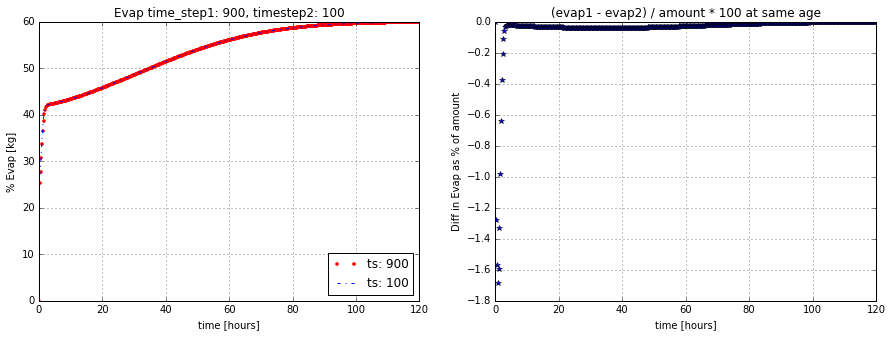

In [6]:
if m1.time_step == m2.time_step:
    ix = 1
else:
    ix = int(m1.time_step / m2.time_step)

print 'Model 2 matches time: {}. At every {} steps.'.format(np.allclose(t1 - t2[0::ix], 0.), ix)
#print 'diff in evap at same time: ', evap1 - evap2[0:len(t2):ix]

plt.figure(1, figsize=(15,5))
plt.subplot(121)

plt.plot(t1 / 3600., evap1 / amount * 100, '.r',
         t2 / 3600., evap2 / amount * 100, '-.b')

plt.xlabel('time [hours]')
plt.ylabel('% Evap [kg]')
plt.legend(['ts: {}'.format(m1.time_step),
            'ts: {}'.format(m2.time_step)],
           loc=4)
plt.title('Evap time_step1: {}, timestep2: {}'.format(m1.time_step, m2.time_step))
plt.grid()

plt.subplot(122)

plt.plot(t1 / 3600., (evap1 - evap2[0::ix]) / amount * 100, '*')

plt.xlabel('time [hours]')
plt.ylabel('Diff in Evap as % of amount')
plt.title('(evap1 - evap2) / amount * 100 at same age')
plt.grid()


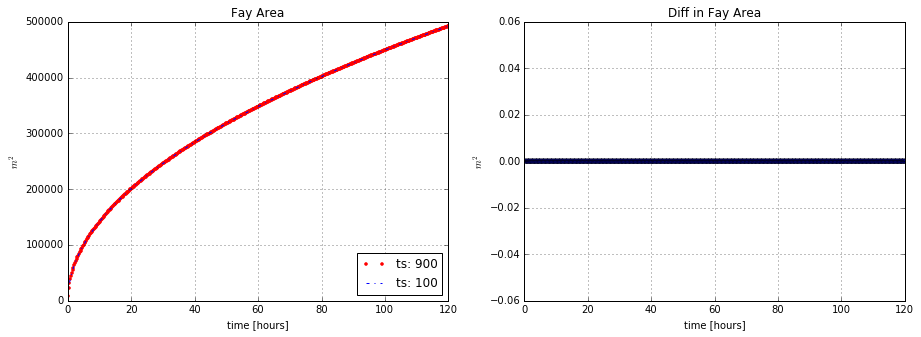

In [7]:
plt.figure(1, figsize=(15,5))
plt.subplot(121)

plt.plot(t1 / 3600., fay_area1, '.r',
         t2 / 3600., fay_area2, '-.b')

plt.xlabel('time [hours]')
plt.ylabel(r'$m^2$')
plt.title('Fay Area')
plt.legend(['ts: {}'.format(m1.time_step),
            'ts: {}'.format(m2.time_step)],
           loc=4)
plt.grid()

idx=0
plt.subplot(122)

plt.plot(t1 / 3600., (fay_area1 - fay_area2[0:len(t2):ix])[idx:], '*')

plt.xlabel('time [hours]')
plt.ylabel(r'$m^2$')
plt.title('Diff in Fay Area')
plt.grid()


After max area is reached, the area no nonger updates.

Looking at Model 2, expected results for init_volume: 44.987 m^3
	terminal thickness:                     1.74567393957e-05 m
	time for inertial gravity phase:        108.0 sec
	days to achieve:                        137.033 days

Model 1 did not run long enough to achieve max_area.





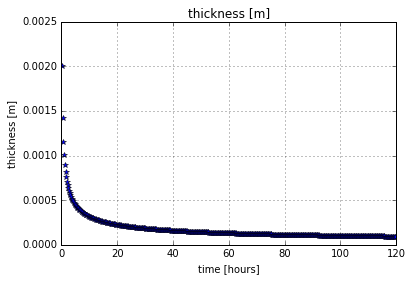

In [8]:
# water viscosity is 1e-6
water = m2.find_by_attr('_ref_as', 'water', m1.environment)
w_vis = water.get('kinematic_viscosity', 'square meter per second')
k = (1.53, 1.21)

vo = sc2['bulk_init_volume'][0]
wd = m1.find_by_class(WeatheringData, m1.weatherers)
spreading = m1.find_by_attr('_ref_as', 'spreading', m1.weatherers)

rel_b = spreading._init_relative_buoyancy
time = np.arange(900, m2.duration.total_seconds(), 900)
thick = 1 / (np.pi * k[1] ** 2) * (vo / (gravity * rel_b * time ** (3. / 2.) / np.sqrt(w_vis))) ** (1. / 3.)

th_lim = spreading.thickness_limit

# compute the time for inital to gravity spreading
t0 = ((k[1] / k[0]) ** 4.0 *
      (vo / (w_vis * gravity * rel_b)) ** (1. / 3.))
c_end_time = (1. / (th_lim * np.pi * k[1] ** 2.0) *
              (vo * np.sqrt(w_vis) / (gravity * rel_b)) ** (1. / 3.)
              ) ** 2. - t0

print 'Looking at Model 2, expected results for init_volume:', np.round(vo, 3), 'm^3'
print '\tterminal thickness: '.ljust(40), th_lim, 'm'
print '\ttime for inertial gravity phase: '.ljust(40), np.round(t0), 'sec'
print '\tdays to achieve: '.ljust(40), np.round(c_end_time / 60 / 60 / 24, 3), 'days'

if t2[-1] >= c_end_time:
    max_ix_2 = np.where(fay_area2 == fay_area2[-1])[0][0]
    
    print '\nModel 1 results:'
    print '\tFinal thickness: '.ljust(20), vo / fay_area2[-1]
    
    print '\nmax area: '.ljust(27), vo / th_lim
    print '\tFinal Area '.ljust(20), fay_area2[-1], ' in: ', np.round(t2[max_ix_2] / 3600. / 24., 3), 'days'
    
    print '\nTime to reach max area is within 2 timesteps:', t2[max_ix_23] - c_end_time
    print 'The model keeps initial area "A0" for first step; and max area is achieved mid-step.'
    print 'So within two timesteps is best that can be achieved.'
else:
    print '\nModel 1 did not run long enough to achieve max_area.'

print '\n==========================================================\n\n'

plt.figure()

plt.plot(time / 3600., thick, '*')

plt.xlabel('time [hours]')
plt.ylabel('thickness [m]')
plt.title('thickness [m]')
plt.grid()


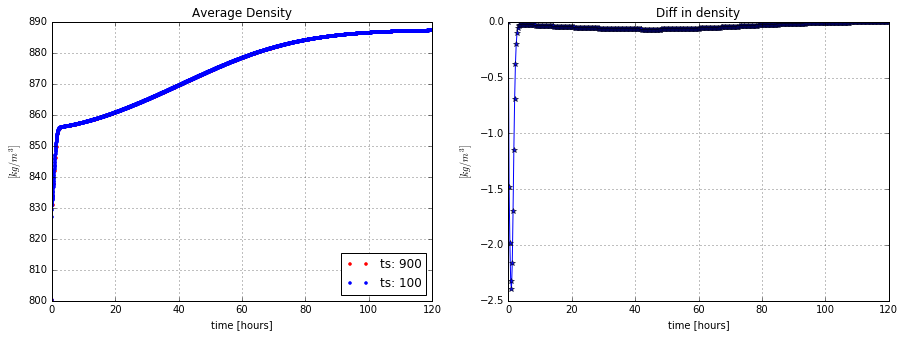

In [9]:
plt.figure(1, figsize=(15,5))
plt.subplot(121)

plt.plot(t1 / 3600., rho1, '.r',
         t2 / 3600., rho2, '.b')

plt.xlabel('time [hours]')
plt.ylabel(r'$[kg/m^3]$')
plt.title('Average Density')
plt.legend(['ts: {}'.format(m1.time_step),
            'ts: {}'.format(m2.time_step)],
           loc=4)
plt.grid()

plt.subplot(122)

plt.plot(t1 / 3600., rho1 - rho2[0:len(t2):ix], '*-')

plt.xlabel('time [hours]')
plt.ylabel(r'$[kg/m^3]$')
plt.title('Diff in density')
plt.grid()
